In [2]:
import sys
sys.path.append('../')
sys.path.append('../WD_models')

### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from astropy.io import fits
from astropy.table import Table, Column, MaskedColumn, join, unique
from astropy.table import vstack

from tqdm import tqdm
import pandas as pd
import WD_models

In [5]:
from astropy.table import Table, join_skycoord
from astropy.coordinates import SkyCoord
from astropy import table
import astropy.units as u

c0 = Table.read('data/base_catalog.fits')
c1 = Table.read('data/03_wd_rv.fits')
nug = fits.open('data/02_photometry.fits')
c2 = Table(nug[1].data)
nug = fits.open('data/04_ms_rv.fits')
c3 = Table(nug[1].data)

print(len(c1))

c1['wd_pos'] = SkyCoord(c1['wd_ra'], c1['wd_dec'], unit='deg')
c2['wd_pos'] = SkyCoord(c2['wd_ra'], c2['wd_dec'], unit='deg')

join_func = table.join_skycoord(5 * u.arcsecond)
catalog = join(c1, c2, keys = 'wd_source_id', join_type = 'inner')

#catalog = join(c1, c2, join_type = 'inner', keys='wd_source_id')
#print(len(catalog))
#catalog = unique(catalog, keys='wd_catalog_id_phot')
#print(len(catalog))

84


In [12]:
c3['ms_source_id_1'] = c3['ms_source_id']
cata2 = join(join(join(c0, c1, keys = 'wd_source_id'), c2, keys = 'wd_source_id'), c3, keys='ms_source_id_1')
print(len(cata2))

85


In [3]:
catalog[catalog['wd_catalog_id'] == 91]

solution_id1,solution_id2,source_id1,source_id2,random_index1,random_index2,ref_epoch1,ref_epoch2,ra1,ra2,ra_error1,ra_error2,dec1,dec2,dec_error1,dec_error2,parallax1,parallax2,parallax_error1,parallax_error2,parallax_over_error1,parallax_over_error2,pm1,pm2,pmra1,pmra2,pmra_error1,pmra_error2,pmdec1,pmdec2,pmdec_error1,pmdec_error2,ra_dec_corr1,ra_dec_corr2,ra_parallax_corr1,ra_parallax_corr2,ra_pmra_corr1,ra_pmra_corr2,ra_pmdec_corr1,ra_pmdec_corr2,dec_parallax_corr1,dec_parallax_corr2,dec_pmra_corr1,dec_pmra_corr2,dec_pmdec_corr1,dec_pmdec_corr2,parallax_pmra_corr1,parallax_pmra_corr2,parallax_pmdec_corr1,parallax_pmdec_corr2,pmra_pmdec_corr1,pmra_pmdec_corr2,astrometric_n_obs_al1,astrometric_n_obs_al2,astrometric_n_obs_ac1,astrometric_n_obs_ac2,astrometric_n_good_obs_al1,astrometric_n_good_obs_al2,astrometric_n_bad_obs_al1,astrometric_n_bad_obs_al2,astrometric_gof_al1,astrometric_gof_al2,astrometric_chi2_al1,astrometric_chi2_al2,astrometric_excess_noise1,astrometric_excess_noise2,astrometric_excess_noise_sig1,astrometric_excess_noise_sig2,astrometric_params_solved1,astrometric_params_solved2,astrometric_primary_flag1,astrometric_primary_flag2,nu_eff_used_in_astrometry1,nu_eff_used_in_astrometry2,pseudocolour1,pseudocolour2,pseudocolour_error1,pseudocolour_error2,ra_pseudocolour_corr1,ra_pseudocolour_corr2,dec_pseudocolour_corr1,dec_pseudocolour_corr2,parallax_pseudocolour_corr1,parallax_pseudocolour_corr2,pmra_pseudocolour_corr1,pmra_pseudocolour_corr2,pmdec_pseudocolour_corr1,pmdec_pseudocolour_corr2,astrometric_matched_transits1,astrometric_matched_transits2,visibility_periods_used1,visibility_periods_used2,astrometric_sigma5d_max1,astrometric_sigma5d_max2,matched_transits1,matched_transits2,new_matched_transits1,new_matched_transits2,matched_transits_removed1,matched_transits_removed2,ipd_gof_harmonic_amplitude1,ipd_gof_harmonic_amplitude2,ipd_gof_harmonic_phase1,ipd_gof_harmonic_phase2,ipd_frac_multi_peak1,ipd_frac_multi_peak2,ipd_frac_odd_win1,ipd_frac_odd_win2,ruwe1,ruwe2,scan_direction_strength_k11,scan_direction_strength_k12,scan_direction_strength_k21,scan_direction_strength_k22,scan_direction_strength_k31,scan_direction_strength_k32,scan_direction_strength_k41,scan_direction_strength_k42,scan_direction_mean_k11,scan_direction_mean_k12,scan_direction_mean_k21,scan_direction_mean_k22,scan_direction_mean_k31,scan_direction_mean_k32,scan_direction_mean_k41,scan_direction_mean_k42,duplicated_source1,duplicated_source2,phot_g_n_obs1,phot_g_n_obs2,phot_g_mean_flux1,phot_g_mean_flux2,phot_g_mean_flux_error1,phot_g_mean_flux_error2,phot_g_mean_flux_over_error1,phot_g_mean_flux_over_error2,phot_g_mean_mag1,phot_g_mean_mag2,phot_bp_n_obs1,phot_bp_n_obs2,phot_bp_mean_flux1,phot_bp_mean_flux2,phot_bp_mean_flux_error1,phot_bp_mean_flux_error2,phot_bp_mean_flux_over_error1,phot_bp_mean_flux_over_error2,phot_bp_mean_mag1,phot_bp_mean_mag2,phot_rp_n_obs1,phot_rp_n_obs2,phot_rp_mean_flux1,phot_rp_mean_flux2,phot_rp_mean_flux_error1,phot_rp_mean_flux_error2,phot_rp_mean_flux_over_error1,phot_rp_mean_flux_over_error2,phot_rp_mean_mag1,phot_rp_mean_mag2,phot_bp_n_contaminated_transits1,phot_bp_n_contaminated_transits2,phot_bp_n_blended_transits1,phot_bp_n_blended_transits2,phot_rp_n_contaminated_transits1,phot_rp_n_contaminated_transits2,phot_rp_n_blended_transits1,phot_rp_n_blended_transits2,phot_proc_mode1,phot_proc_mode2,phot_bp_rp_excess_factor1,phot_bp_rp_excess_factor2,bp_rp1,bp_rp2,bp_g1,bp_g2,g_rp1,g_rp2,dr2_radial_velocity1,dr2_radial_velocity2,dr2_radial_velocity_error1,dr2_radial_velocity_error2,dr2_rv_nb_transits1,dr2_rv_nb_transits2,dr2_rv_template_teff1,dr2_rv_template_teff2,dr2_rv_template_logg1,dr2_rv_template_logg2,dr2_rv_template_fe_h1,dr2_rv_template_fe_h2,l1,l2,b1,b2,ecl_lon1,ecl_lon2,ecl_lat1,ecl_lat2,pairdistance,sep_AU,binary_type,Sigma18,R_chance_align,dr2_source_id1,dr2_source_id2,dr2_parallax1,dr2_parallax2,dr2_parallax_error1,dr2_parallax_error2,dr2_pmra1,dr2_pmra2,dr2_pmdec1,dr2_pmdec2,dr2_pmra_error1,dr2

In [4]:
print(len(catalog))

85


In [5]:
model = WD_models.load_model('f', 'f', 'f', 'H')
font_model = model

c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

def rv_from_radius(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f'):
    
    if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
        font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    else:
        font_model = model

    #     font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')


    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**font_model['logteff'],\
                                                z = font_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)

    return rv*1e-3

<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_42219/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_42219/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_42219/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':


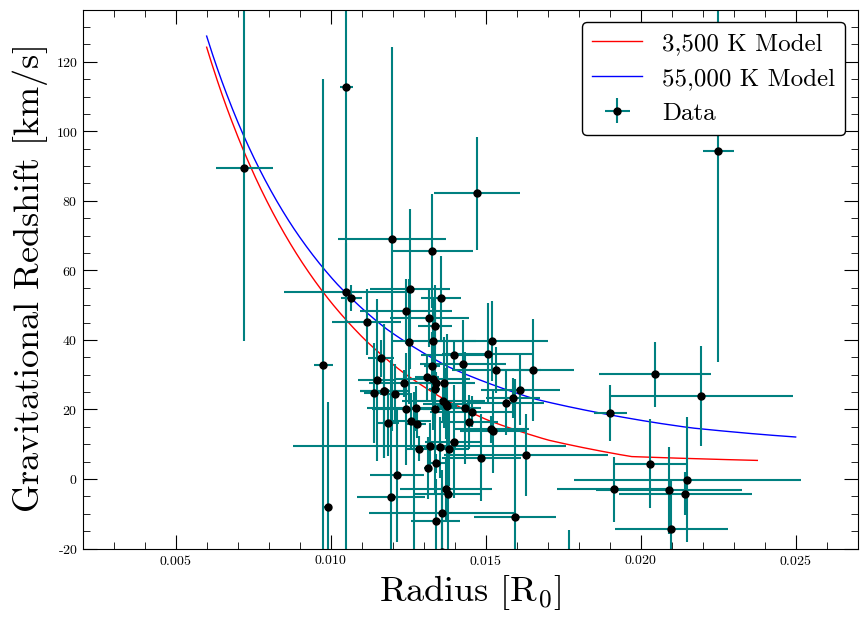

In [6]:
plt.figure(figsize=(10,7))
plt.style.use('./stefan.mplstyle')

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

plt.errorbar(catalog['radius'], catalog['g_redshift'], xerr = catalog['e_radius'], yerr=catalog['eg_redshift'], fmt='o', label = 'Data', color='black', ecolor = 'teal')

plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.002, 0.027)
plt.ylim(-20, 135)
plt.legend()

In [7]:
#np.all([catalog['program'] == 5], axis = 0)
#clean = np.logical_or(catalog['clean'], np.all([catalog['program'] == 5], axis = 0))

clean = np.all([catalog['clean'] == 1], axis = 0)

In [8]:
print(catalog['wd_catalog_id_phot'][clean])

wd_catalog_id_phot
------------------
                23
                24
                27
                29
                30
                31
                35
                39
                41
                44
               ...
               153
               154
               158
               159
               160
               162
               163
               166
               168
               172
Length = 67 rows


In [9]:
''' GENERATE MASK FROM FLAGS '''

rechi = np.all([catalog['rechi'] < 10], axis = 0)
redchi = np.all([catalog['redchi'] < 10], axis = 0)
snr = np.all([catalog['snr'] > 2], axis = 0)
chance = np.all([catalog['R_chance_align'] < 0.01], axis = 0)

not_da = np.ones(len(catalog))
for i in range(len(not_da)):
    if catalog['wd_catalog_id'][i] == 143.0:
        not_da[i] = 0

#corv_err = np.all([catalog['eg_redshift'] < 100], axis = 0)

mask = np.all([redchi, rechi, snr, chance, not_da], axis = 0)
mask2 = np.all([redchi, rechi, clean, chance], axis = 0)

print(len(catalog[mask]))

56


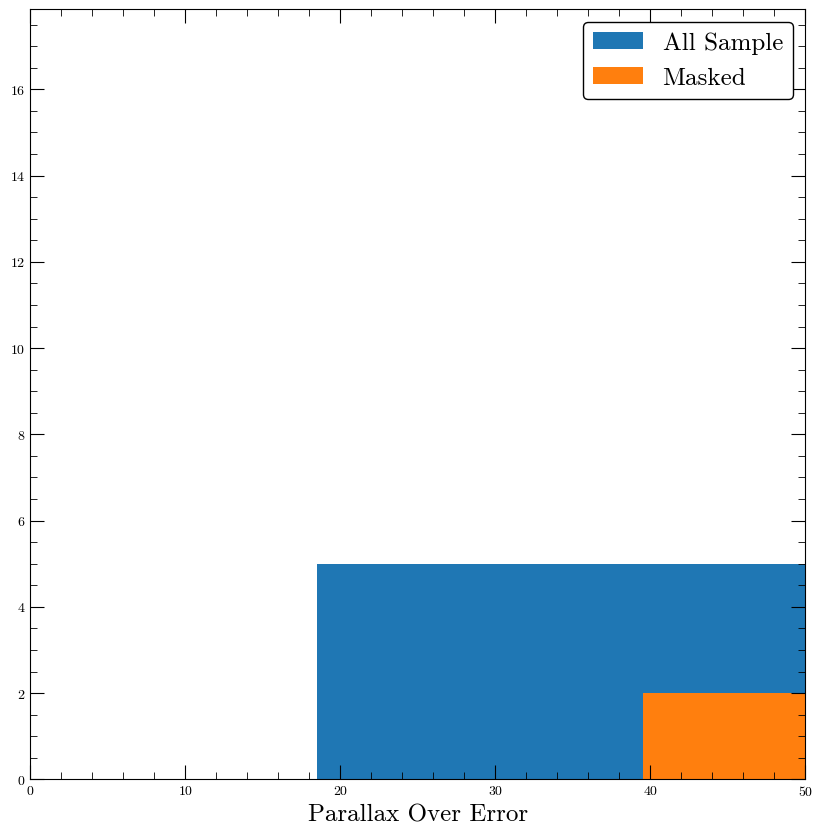

In [10]:
plt.figure(figsize=(10,10))
plt.hist(catalog['ms_parallax_over_error'], bins = 20, label = 'All Sample')
plt.hist(catalog['ms_parallax_over_error'][mask], bins = 20, label = 'Masked')

ymin, ymax = plt.ylim()
plt.xlim(0,50)
#plt.vlines(np.mean(catalog['phot_teff']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Parallax Over Error', fontsize=18)
plt.legend()

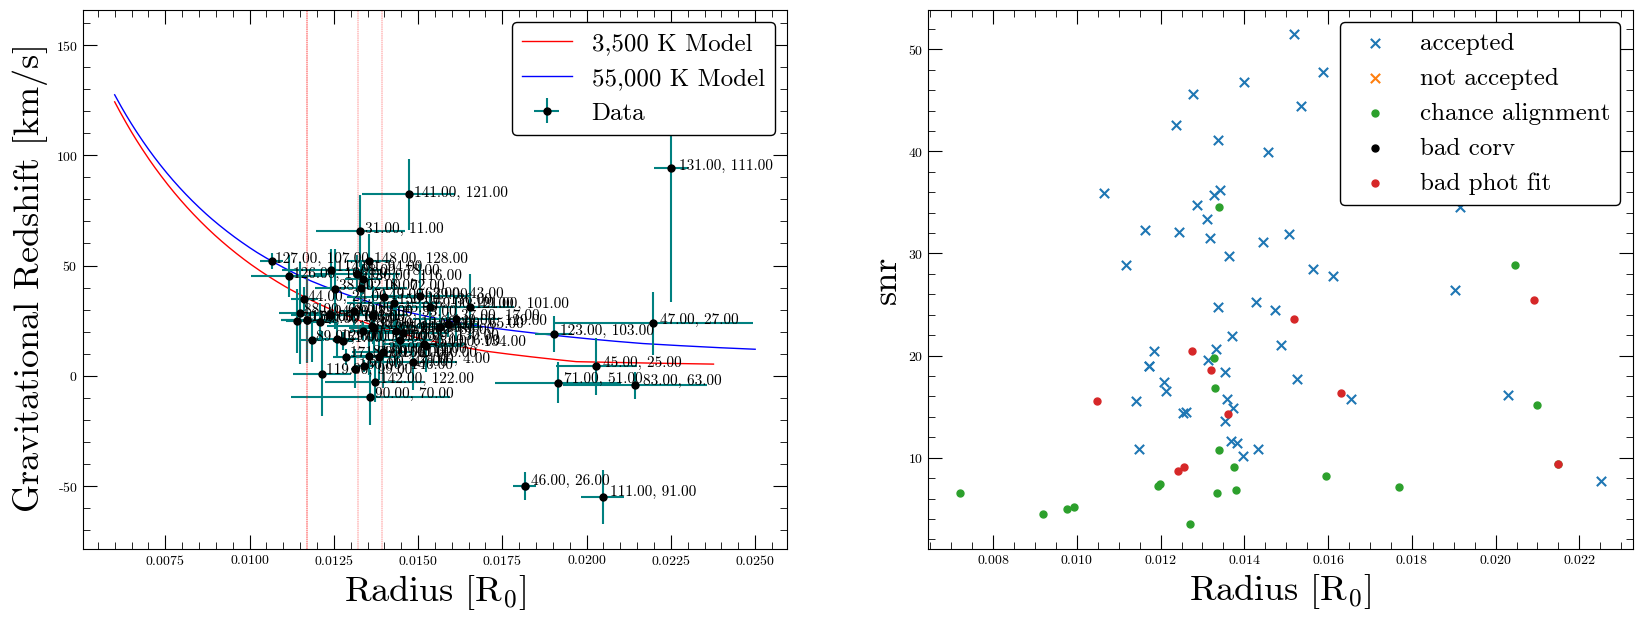

In [19]:
''' PLOTTING '''

plt.figure(figsize=(20,7))

plt.subplot(1,2,1) 

plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

for i in range(len(catalog['radius'][mask])):
    x = catalog['radius'][mask][i]
    y = catalog['g_redshift'][mask][i]
 #   plt.plot(x, y, 'bo')
    
    #if (0.006 < x < 0.025) and (-50 < y < 120):
    plt.text(x * (1 + 0.01), y * (1 - 0.01) , ('%2.2f, %2.2f' % (catalog['wd_catalog_id_phot'][mask][i], catalog['wd_catalog_id'][mask][i])), fontsize=11)
    
# Data

plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr=catalog['eg_redshift'][mask], fmt='o', label = 'Data', color='black', ecolor = 'teal')
#plt.errorbar(catalog['radius'][catalog['wd_catalog_id'] == 49], catalog['g_redshift'][catalog['wd_catalog_id'] == 49],
#            xerr = catalog['e_radius'][catalog['wd_catalog_id'] == 49], yerr = catalog['eg_redshift'][catalog['wd_catalog_id'] == 49])

plt.scatter(catalog['radius'][catalog['wd_catalog_id'] == 26], catalog['g_redshift'][catalog['wd_catalog_id'] == 26])


refs = Table.read('sdss5/ms_gaia_wd_sdss5.fits')
ms_stuff = Table.read('data/ms_sdss4_wd_sdss4.fits')

for i in range(len(c2)):
    if (c2['wd_source_id'][i] in refs['wd_source_id']):
        plt.axvline(x=c2['radius'][i], ls='--', c='red', lw=0.3)
    elif (c2['wd_source_id'][i] in refs['wd_source_id']):
        plt.axvline(x=c2['radius'][i], ls=':', c='green', lw=0.3)


plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
#plt.xlim(0.006, 0.025)
#plt.ylim(0, 120)
plt.legend()

plt.subplot(1,2,2) 

#plt.figure(figsize=(10,7))
plt.style.use('./stefan.mplstyle')


#plt.scatter(catalog['radius'], catalog['snr'], label='base')
plt.scatter(catalog['radius'][mask], catalog['snr'][mask], label='accepted', marker = 'x', s = 45)
plt.scatter(catalog['radius'][~snr], catalog['snr'][~snr], label='not accepted', marker = 'x', s = 45)
plt.scatter(catalog['radius'][~chance], catalog['snr'][~chance], label='chance alignment')
plt.scatter(catalog['radius'][~rechi], catalog['snr'][~rechi], label='bad corv', color = 'black')
plt.scatter(catalog['radius'][~redchi], catalog['snr'][~redchi], label='bad phot fit')


#for i in range(len(catalog['radius'])):
#    x = catalog['radius'][i]
#    y = catalog['snr'][i]
#    plt.text(x * (1 + 0.01), y * (1 - 0.01) , ('%2.2f' % (catalog['wd_catalog_id_phot'][i])), fontsize=11)


plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'snr')
plt.legend()

In [12]:
print(catalog.keys())

['solution_id1', 'solution_id2', 'source_id1', 'source_id2', 'random_index1', 'random_index2', 'ref_epoch1', 'ref_epoch2', 'ra1', 'ra2', 'ra_error1', 'ra_error2', 'dec1', 'dec2', 'dec_error1', 'dec_error2', 'parallax1', 'parallax2', 'parallax_error1', 'parallax_error2', 'parallax_over_error1', 'parallax_over_error2', 'pm1', 'pm2', 'pmra1', 'pmra2', 'pmra_error1', 'pmra_error2', 'pmdec1', 'pmdec2', 'pmdec_error1', 'pmdec_error2', 'ra_dec_corr1', 'ra_dec_corr2', 'ra_parallax_corr1', 'ra_parallax_corr2', 'ra_pmra_corr1', 'ra_pmra_corr2', 'ra_pmdec_corr1', 'ra_pmdec_corr2', 'dec_parallax_corr1', 'dec_parallax_corr2', 'dec_pmra_corr1', 'dec_pmra_corr2', 'dec_pmdec_corr1', 'dec_pmdec_corr2', 'parallax_pmra_corr1', 'parallax_pmra_corr2', 'parallax_pmdec_corr1', 'parallax_pmdec_corr2', 'pmra_pmdec_corr1', 'pmra_pmdec_corr2', 'astrometric_n_obs_al1', 'astrometric_n_obs_al2', 'astrometric_n_obs_ac1', 'astrometric_n_obs_ac2', 'astrometric_n_good_obs_al1', 'astrometric_n_good_obs_al2', 'astrometri

In [13]:
print(catalog[['wd_catalog_id_phot', 'wd_bp_rp']][~redchi])
print(catalog[['wd_catalog_id_phot', 'wd_bp_rp']][~clean])

wd_catalog_id_phot   wd_bp_rp  
------------------ ------------
                28   0.71481895
                64   0.64445114
                74   0.25636482
                82    0.4567623
                97  -0.39578438
               122    0.5459995
               132    0.4638424
               159     0.596159
               164 -0.016479492
               165   -0.2847538
wd_catalog_id_phot    wd_bp_rp  
------------------ -------------
                26    -0.2644558
                28    0.71481895
                34    0.40981293
                37    -0.3186779
                38    0.17695999
                47    -0.4969864
                69   -0.13117409
               104 -0.0052814484
               121    0.33911896
               122     0.5459995
               131    0.48410225
               141   -0.13069153
               142   -0.15182877
               148    0.55765724
               156   -0.15055656
               164  -0.016479492
               165    

In [14]:
import os

for i in range(len(catalog[~redchi])):
    id_ = catalog['wd_catalog_id_phot'][~redchi][i]
    
    os.system('cp spectra/leastsq/phot_fit/{}.png spectra/leastsq/bad_photometry/'.format(int(id_)))
    
for i in range(len(catalog[~clean])):
    id_ = catalog['wd_catalog_id_phot'][~clean][i]
    
    os.system('cp spectra/leastsq/phot_fit/{}.png spectra/leastsq/unclean/'.format(int(id_)))

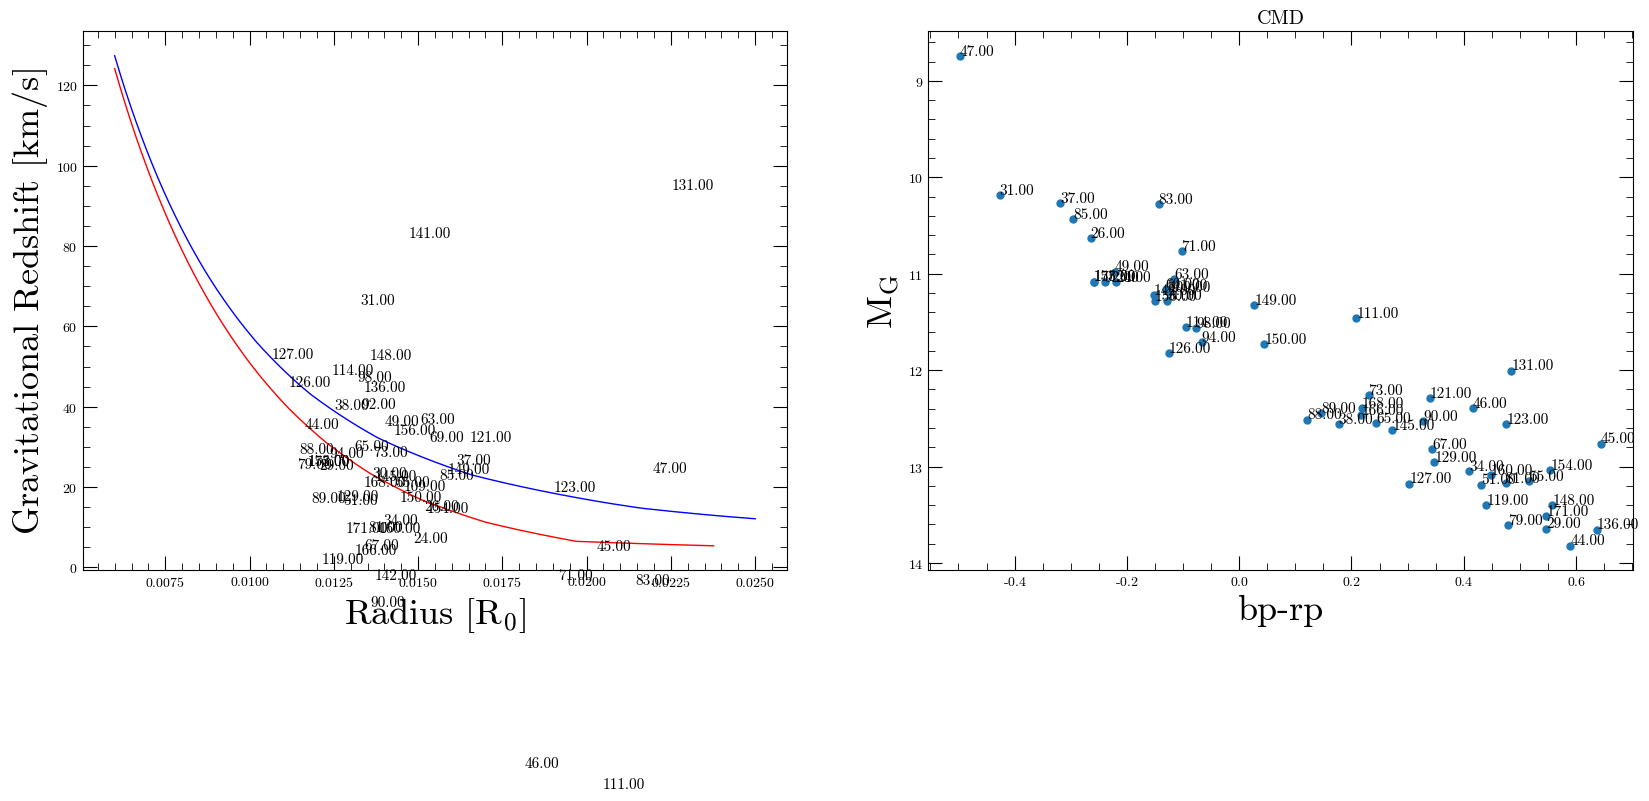

In [15]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1) 

plt.style.use('./stefan.mplstyle')

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

i = 51

#plt.errorbar(catalog['radius'][catalog['wd_catalog_id'] == i], catalog['g_redshift'][catalog['wd_catalog_id'] == i],
#            xerr = catalog['e_radius'][catalog['wd_catalog_id'] == i], yerr = catalog['eg_redshift'][catalog['wd_catalog_id'] == i])

for i in range(len(catalog['radius'][mask])):
    x = catalog['radius'][mask][i]
    y = catalog['g_redshift'][mask][i]
    plt.text(x, y , ('%2.2f' % (catalog['wd_catalog_id_phot'][mask][i])), fontsize=11)
    
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')

plt.subplot(1,2,2) 

plt.style.use('./stefan.mplstyle')
plt.scatter(catalog['wd_bp_rp'][mask], catalog['wd_m_g'][mask])

for i in range(len(catalog['radius'][mask])):
    x = catalog['wd_bp_rp'][mask][i]
    y = catalog['wd_m_g'][mask][i]
    plt.text(x * (1 + 0.001), y * (1 - 0.001) , ('%2.2f' % (catalog['wd_catalog_id_phot'][mask][i])), fontsize=11)
    
plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()

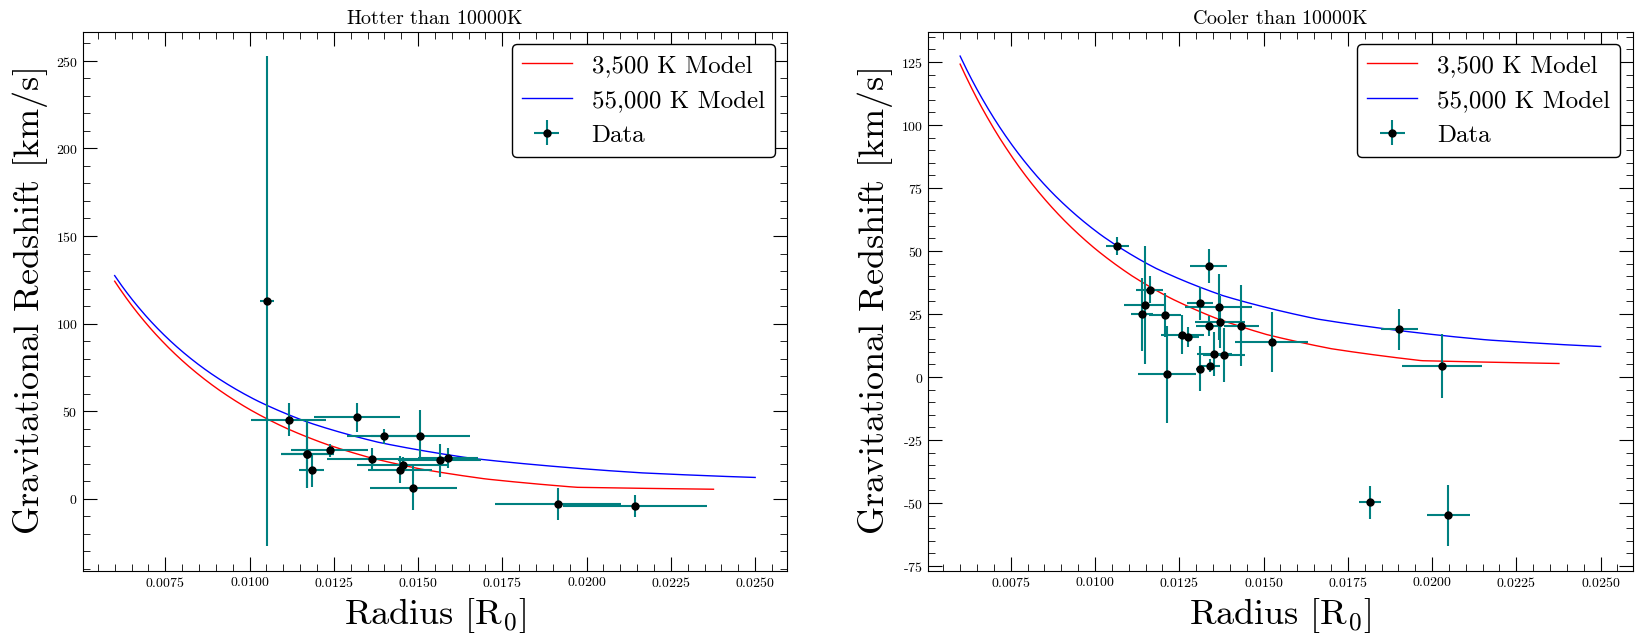

In [16]:
hot_catalog = catalog[catalog['phot_teff_1'] > 10000].copy()
cool_catalog = catalog[catalog['phot_teff_1'] < 10000].copy()

hot_clean = hot_catalog['clean']
hot_rechi = np.all([hot_catalog['rechi'] < 5], axis = 0)
hot_redchi = np.all([hot_catalog['redchi'] < 5], axis = 0)
hot_snr = np.all([hot_catalog['snr'] > 5], axis = 0)
hot_chance = np.all([hot_catalog['R_chance_align'] < 0.01], axis = 0)
hot_mask = np.all([hot_redchi, hot_rechi, hot_clean, hot_snr, hot_chance], axis = 0)

cool_clean = cool_catalog['clean']
cool_rechi = np.all([cool_catalog['rechi'] < 5], axis = 0)
cool_redchi = np.all([cool_catalog['redchi'] < 5], axis = 0)
cool_snr = np.all([cool_catalog['snr'] > 5], axis = 0)
cool_chance = np.all([cool_catalog['R_chance_align'] < 0.01], axis = 0)
cool_mask = np.all([cool_redchi, cool_rechi, cool_clean, cool_snr, cool_chance], axis = 0)

''' PLOTTING '''

plt.figure(figsize=(20,7))
plt.subplot(1,2,1) 
plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

# Data

plt.errorbar(hot_catalog['radius'][hot_mask], hot_catalog['g_redshift'][hot_mask], xerr = hot_catalog['e_radius'][hot_mask],
             yerr=hot_catalog['eg_redshift'][hot_mask], fmt='o', label = 'Data', color='black', ecolor = 'teal')

plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.title(r'Hotter than $10000$K')
plt.legend()

plt.subplot(1,2,2) 
plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

# Data

plt.errorbar(cool_catalog['radius'][cool_mask], cool_catalog['g_redshift'][cool_mask], xerr = cool_catalog['e_radius'][cool_mask], 
             yerr=cool_catalog['eg_redshift'][cool_mask], fmt='o', label = 'Data', color='black', ecolor = 'teal')

plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.title(r'Cooler than $10000$K')
plt.legend()

In [17]:
from astroquery.sdss import SDSS

spec = SDSS.get_spectra(plate=test['wd_plate'], fiberID=test['wd_fiberid'], mjd=test['wd_mjd'])[0]

#print(spec[4].header)

wl = (10**spec[1].data['loglam'])
fl = (spec[1].data['flux'])
ivar = (spec[1].data['ivar'])

NameError: name 'test' is not defined

In [ ]:
wavl_range = (0<wl)*(wl<9000)

plt.plot(wl[wavl_range], fl[wavl_range])

In [ ]:
max(wl)

In [ ]:
min(wl)